In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
np.random.seed(2017)
from scipy.fft import fft, ifft
from Scripts.modelRepr import RingModel, Input, perturbedRingModel, model_from_image
from Scripts.ISTrans import series_signal2img
from Scripts.ISTransConfig import *
from Scripts.Tools.vectorTrans import trans_kernel, itrans_kernel

You have imported a iterative solver.
You have imported a iterative solver.


# 模型与方法

In [2]:
# 定义一个空类，下面会用来存参数
class Dummy:
    pass

# def naka(C, fmax, C_50, p=3.5):
#     return fmax*C**p/(C_50**p + C**p)

# def naka_inv(contrasts, fmax, C_50, p=3.5):
#     return (C_50**p/fmax/(1/contrasts - 1/fmax))**(1/p)

def single_gaussian(theta, center, size_ext, periodic=True):
    if periodic: 
        return np.exp(-(theta - center)**2/(2*size_ext**2))+np.exp(-(theta - center+180)**2/(2*size_ext**2))+np.exp(-(theta - center-180)**2/(2*size_ext**2))
    else:
        return np.exp(-(theta - center)**2/(2*size_ext**2))
    
def sin_input(theta,fre,amp):
    return np.sin(2*np.pi*theta/180*fre)*amp

def cos_input(theta,fre,amp):
    return np.cos(2*np.pi*theta/180*fre)*amp

def average_firing_rate(step, dtime: second, spike_mon: SpikeMonitor):
    time_range = np.linspace(0, step*dtime/second, step+1, endpoint=True).reshape(-1, 1)*second
    train = spike_mon.spike_trains()
    avg_rate = np.array([np.sum(((time_range[:step] <= train[i])&(time_range[1:] > train[i])).astype(int), axis=1)/dtime for i in range(len(train))])
    return avg_rate.T

def average_current(step, dtime, state: StateMonitor, name: str):
    time_range = np.linspace(0, step*dtime/second, step+1, endpoint=True).reshape(-1, 1)*second
    I = eval(f'state.{name}/pA')
    avg_current = np.array([np.average(I[:, (time_range[i] <= state.t)&(time_range[i+1] > state.t)], axis=1) for i in range(step)])
    return avg_current

# 初始化参数与方程
def default_params():
    params = Dummy()
    init_network(params, 
    # 不用管的参数：
    C=10,dtime=10*second,C_bg=0,W=1.028,center=45,size_ext=25,sparsity=1, failure_rate=.5, sparsityEE=1,sparsityEI=1,sparsityIE=1,sparsityII=1,fmax=100.1,C_50=20,
    # 神经元个数与输入的参数，其中N_input用来控制poisson input的方差
    N = 120,N_input=1,
    # 时间常数
    tau_m=15*ms, tau_E=3*ms, tau_I=3*ms, tau_ref=0*ms,
    # 连接强度
    g_EI=1.42*nS, g_II=1.2*nS, g_EE=1.8*nS, g_IE= 2.06*nS, g_L=10*nS,
    # reversal potential
    R_L=-70*mV,  R_E=0*mV, R_I=-80*mV, V_th=-50*mV, V_r=-56*mV,
    # 侧向连接的参数，sigma_ori是连接宽度
    A=0, B=1, sigma_ori=25,
    # 周期性输入的参数
    fre=0,amp=0,Cs=30,
    # 神经元的动力学方程
    E_eqs_neurons ="""
    dv/dt = (-(v - R_L) + (R_E - v)*g_E/g_L +  (R_I - v)*g_I/g_L + (R_E - v)*g_in/g_L)/tau_m : volt (unless refractory)
    dg_E/dt = -g_E/tau_E : siemens
    dg_I/dt = -g_I/tau_I : siemens
    dg_in/dt = -g_in/tau_E: siemens
    I_exc = g_E*(R_E - v): ampere
    I_inh = abs(g_I*(R_I - v)): ampere
    I_ext = g_in*(R_E - v): ampere
    I_net = g_I*(R_I - v) + g_in*(R_E - v) + g_E*(R_E - v) : ampere
    theta : 1
    """,
    I_eqs_neurons ="""
    dv/dt = (-(v - R_L) + (R_E - v)*g_E/g_L +  (R_I - v)*g_I/g_L + (R_E - v)*g_in/g_L)/tau_m : volt (unless refractory)
    dg_E/dt = -g_E/tau_E : siemens
    dg_I/dt = -g_I/tau_I : siemens
    dg_in/dt = -g_in/tau_E: siemens
    I_exc = g_E*(R_E - v): ampere
    I_inh = abs(g_I*(R_I - v)): ampere
    I_ext = g_in*(R_E - v): ampere
    I_net = g_I*(R_I - v) + g_in*(R_E - v) + g_E*(R_E - v) : ampere
    theta : 1
    """,
    # 连接的方程
    w_eqs = "w = int(abs(theta_pre-theta_post)<=90)*(A + B*exp(-(abs(theta_pre-theta_post)/(sqrt(2)*sigma_ori))**2)) + int(abs(theta_pre-theta_post)>90)*(A + B*exp(-((180-abs(theta_pre-theta_post))/(sqrt(2)*sigma_ori))**2)): 1 "
    )
    return params


def init_network(params, input_shape="single_gaussian", time_dependency=None, cpp_standalone = True, **kwargs):
    start_scope()
    # 使用cpp standalone （这个需要g++）
    if cpp_standalone:
        device.reinit()
        device.activate()
        pid = os.getpid()
        directory = f"standalone{pid}"
        set_device('cpp_standalone', directory=directory)

    for key, value in kwargs.items():
        params.__dict__.update({key: value})
    
    params.sparsityEE = params.sparsityEE
    params.sparsityIE = params.sparsityIE
    params.sparsityEI = params.sparsityEI
    params.sparsityII = params.sparsityII
    params.theta = np.arange(0, params.N)/params.N*180

    # 外界输入的参数，其中在基频输入时保证g_ext*r_ext=10
    # params.g_ext = ((np.ones(params.N)*10/params.N_input + cos_input(np.arange(0,params.N)/params.N*180,params.fre,params.amp))/params.N_input).reshape((-1, params.N))*nS
    params.g_ext = TimedArray(((np.ones(params.N)*10 + cos_input(np.arange(0,params.N)/params.N*180,params.fre,params.amp))/params.N_input).reshape((-1, params.N))*nS, dt=params.dtime)
    # params.g_ext = TimedArray(ones(params.N)*10/params.N_input*nS + params.amp*cos(2*params.fre*params.theta)/params.N_input*nS, dt=params.dtime)
    params.g_ext_I = 10/params.N_input*nS
    params.r_ext = TimedArray(params.Cs*np.ones((1,params.N)).reshape((-1, params.N))*Hz, dt=params.dtime)
    # print(params.g_ext(1*second,1))
    
    # 初始化神经元
    # params.neurons = NeuronGroup(2*params.N, model=params.eqs_neurons, threshold='v>V_th', reset='v=V_r', refractory=params.tau_ref, method='euler', name="neurons")
    params.E_neurons = NeuronGroup(params.N, model=params.E_eqs_neurons, threshold='v>V_th', reset='v=V_r', refractory=params.tau_ref, method='euler', name="E_neurons")
    params.I_neurons = NeuronGroup(params.N, model=params.I_eqs_neurons, threshold='v>V_th', reset='v=V_r', refractory=params.tau_ref, method='euler', name="I_neurons")
    # 初始化输入PoissonGroup，即输入是一个Poisson过程，rates即Poisson过程的参数，其与每一个神经元1-1对应连接
    params.g_input_E = PoissonGroup(params.N, rates="N_input*r_ext(t, i)", name="poisson_E")    # Poission Input External Neurons
    params.g_input_I = PoissonGroup(params.N, rates="N_input*r_ext(t, i)", name="poisson_I")    # Poission Input External Neurons
    params.input_to_G_E = Synapses(params.g_input_E, params.E_neurons, on_pre='g_in += g_ext(t,i)', name="input_to_G_E") # Setting firing condition,
    params.input_to_G_I = Synapses(params.g_input_I, params.I_neurons, on_pre='g_in += g_ext_I', name="input_to_G_I") # Setting firing condition,
    params.g_background = PoissonGroup(params.N, rates="N_input*C_bg*Hz", name='background')
    params.background_to_G = Synapses(params.g_background, params.E_neurons, on_pre='g_in += g_ext', name="background_to_G") # Setting firing condition,
    # params.background_to_G = Synapses(params.g_background, params.I_neurons, on_pre='g_in += g_ext', name="background_to_G") # Setting firing condition,
    # 设定神经元之间的连接
    params.E_to_E = Synapses(params.E_neurons, params.E_neurons, model=params.w_eqs, on_pre='g_E+=W*w*g_EE', name="E_to_E")
    params.I_to_E = Synapses(params.I_neurons, params.E_neurons, model=params.w_eqs, on_pre='g_I+=W*w*g_EI', name="I_to_E")
    params.E_to_I = Synapses(params.E_neurons, params.I_neurons, model=params.w_eqs, on_pre='g_E+=W*w*g_IE', name="E_to_I")
    params.I_to_I = Synapses(params.I_neurons, params.I_neurons, model=params.w_eqs, on_pre='g_I+=W*w*g_II', name="I_to_I")

def build_network(params):
    # 设置基础参数与连接
    params.E_neurons.v = params.V_r
    params.I_neurons.v = params.V_r
    params.E_neurons.theta = params.theta
    params.I_neurons.theta = params.theta
    params.E_to_E.connect(p=params.sparsityEE), params.I_to_E.connect(p=params.sparsityIE), params.E_to_I.connect(p=params.sparsityEI), params.I_to_I.connect(p=params.sparsityII)
    params.input_to_G_E.connect(j='i'),  params.input_to_G_I.connect(j='i'), params.background_to_G.connect(j='i')
    params.spike_E = SpikeMonitor(params.E_neurons)
    params.spike_I = SpikeMonitor(params.I_neurons)
    network = Network(name='network')
    network.add([params.E_neurons,params.I_neurons,params.g_input_E,params.g_input_I,params.input_to_G_E,params.input_to_G_I,params.E_to_E,params.I_to_E,params.E_to_I,params.I_to_I])
    if params.C_bg>0: network.add([params.g_background, params.background_to_G])
    network.add([params.spike_E,params.spike_I])
    # network.store()
    params.network = network

def run_network(params, duration: second, variables=['I_exc', 'I_inh', 'I_ext', 'I_net', 'g_in', 'g_E', 'g_I','v']):
    # device.reinit()
    # device.activate()
    # set_device('cpp_standalone', directory='STDP_standalone')
    # print(f'RUNNING')

    # 设置网络需要记录什么参数
    params.state_E = StateMonitor(params.E_neurons, variables=variables, record=True, dt=10*ms)
    params.state_I = StateMonitor(params.I_neurons, variables=variables, record=True, dt=10*ms)
    params.network.add([params.state_E,params.state_I])
    defaultclock.dt = 0.001*ms # 设置网络运行步长，即数值求解ode的步长
    params.network.run(duration, namespace=params.__dict__)

def save_results(params: dict, fig: plt.figure, note: str):
    now = datetime.now().strftime("%m_%d %H_%M_%S")
    with open('./params/'+now+note+'.txt', 'w') as file:
        file.write(str(params.__dict__))
    fig.savefig('./plots/'+now+note+'.jpg')

def result_monitor(params,C_total,dtime=1*second):
    # 记录需要的参数并运行网路
    C_total = np.asarray(C_total)
    init_network(params, time_dependency="contrast", Cs=C_total, dtime=dtime, center=45)
    build_network(params)
    run_network(params, duration=dtime)
    rates_E = average_firing_rate(1, dtime, params.spike_E)
    rates_I = average_firing_rate(1,dtime,params.spike_I)
    print(rates_E)
    return rates_E,rates_I,params.state_E.I_ext,params.state_I.I_ext,params.state_E.I_net,params.state_I.I_net

def result_monitor1(params,C_total,dtime=1*second):
    # 记录需要的参数并运行网路，此处多输出了excitation current
    C_total = np.asarray(C_total)
    init_network(params, time_dependency="contrast", Cs=C_total, dtime=dtime, center=45)
    build_network(params)
    run_network(params, duration=dtime)
    rates_E = average_firing_rate(1, dtime, params.spike_E)
    rates_I = average_firing_rate(1,dtime,params.spike_I)
    return rates_E,rates_I,params.state_E.I_ext,params.state_I.I_ext,params.state_E.I_net,params.state_I.I_net,params.state_E.I_exc,params.state_I.I_exc

def frequency_change(C_in=200,amp=1,start_fre=0,fre_range=10,**kwargs):
    # 完成一组参数下不同频率的响应，即amp是波动幅度，start_fre是开始的输入频率，fre_range是输入频率的范围，**kwarg可以传入更多网络相关的参数
    params = default_params()
    params.amp = amp
    for key, value in kwargs.items():
        params.__dict__.update({key: value})

    rates_E_record = []
    rates_I_record = []
    E_spike_t_record = []
    E_spike_i_record = []
    I_spike_t_record = []
    I_spike_i_record = []   
    E_ext_record = []
    E_net_record = []
    I_ext_record = []
    I_net_record = []
    E_exc_record = []
    I_exc_record = []

    for fre in range(start_fre,fre_range):       
        params.fre = fre
        rates_E, rates_I,E_ext,I_ext,E_net,I_net,E_exc,I_exc = result_monitor1(params, C_total= C_in, dtime=10*second)
        rates_E_record.append(rates_E[0])
        rates_I_record.append(rates_I[0])
        E_spike_t_record.append(params.spike_E.t[:])
        E_spike_i_record.append(params.spike_E.i[:])
        I_spike_t_record.append(params.spike_I.t[:])
        I_spike_i_record.append(params.spike_I.i[:])
        E_ext_record.append(E_ext)
        E_exc_record.append(E_exc)
        E_net_record.append(E_net)
        I_ext_record.append(I_ext)
        I_exc_record.append(I_exc)
        I_net_record.append(I_net)
    return rates_E_record, rates_I_record, E_spike_t_record, E_spike_i_record,E_ext_record,I_ext_record,E_net_record,I_net_record,E_exc_record,I_exc_record

def frequency_test(C_in=200,amp=1,start_fre=0,fre_range=10,amp_start=0,**kwargs):
    # 完成频响的计算，
    # C_in是输入强度amp是波动幅度，start_fre是开始的输入频率，fre_range是输入频率的范围，**kwarg可以传入更多网络相关的参数
    if amp_start == 0:
        rates_E0,rates_I0,E_spiket0,E_spikei0,E_ext0,I_ext0,E_net0,I_net0,E_exc0,I_exc0 = frequency_change(C_in=C_in,amp=amp_start,start_fre=start_fre,fre_range=start_fre+1,**kwargs)
    else:
        rates_E0,rates_I0,E_spiket0,E_spikei0,E_ext0,I_ext0,E_net0,I_net0,E_exc0,I_exc0 = frequency_change(C_in=C_in,amp=amp_start,start_fre=start_fre,fre_range=fre_range,**kwargs)
    rates_E1,rates_I1,E_spiket1,E_spikei1,E_ext1,I_ext1,E_net1,I_net1,E_exc1,I_exc1 = frequency_change(C_in=C_in,amp=amp_start+amp,start_fre=start_fre,fre_range=fre_range,**kwargs)
    delta_record = []
    if amp_start == 0:
        for i in range (0,fre_range-start_fre):
            current_change=(abs(np.fft.fft(mean(E_ext1[i][:,1:],1)/pA-mean(E_ext0[0][:,1:],1)/pA)))[i+start_fre]
            fre_change = (abs(np.fft.fft(rates_E1[i]-rates_E0[0])))[i+start_fre]
            delta_record.append(fre_change/current_change)
    else:
        for i in range (0,fre_range-start_fre):
            current_change=(abs(np.fft.fft(mean(E_ext1[i][:,1:],1)/pA-mean(E_ext0[i][:,1:],1)/pA)))[i+start_fre]
            fre_change = (abs(np.fft.fft(rates_E1[i]-rates_E0[i])))[i+start_fre]
            delta_record.append(fre_change/current_change)
    return delta_record,rates_E0,rates_E1,E_ext0,E_ext1,I_ext0,I_ext1,E_net0,E_net1,E_spiket0,E_spikei0,E_spiket1,E_spikei1,rates_I0,rates_I1,E_exc0,E_exc1

# 理论模型
def theory_model(g_EE,g_EI,g_IE,sigma,frequency):
    return 1/(1-g_EE*np.sqrt(2*np.pi)*sigma*np.exp(-2*np.pi**2*sigma**2*(frequency/180)**2)+2*np.pi*g_EI*g_IE*sigma**2*np.exp(-4*np.pi**2*sigma**2*(frequency/180)**2))

# 对于不同输入的响应的实验

## No connection

In [4]:
delta_record0,r00,r01,E_ext00,E_ext01,I_ext00,I_ext01,E_net00,E_net01,E_spiket00,E_spikei00,E_spiket01,E_spikei01,rates_I00,rates_I01,E_exc00,E_exc01 = frequency_test(C_in=400,amp=0.4,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

[[513.4 514.3 514.  514.2 514.1 514.2 512.9 513.6 513.7 514.1 512.9 514.5
  515.3 513.8 514.8 513.5 513.9 513.2 513.7 512.5 512.5 514.2 512.5 513.7
  514.9 514.  514.1 514.2 512.8 513.2 514.1 513.1 514.6 513.8 515.1 514.3
  514.1 513.6 512.6 512.5 514.4 512.9 513.9 512.9 513.8 515.6 513.2 513.9
  514.  514.2 514.5 514.2 513.8 512.9 514.1 513.4 514.3 513.4 514.6 513.9
  514.1 514.7 513.6 513.4 514.8 514.4 513.5 513.7 513.3 513.1 513.5 513.6
  513.  513.2 512.7 514.9 513.5 512.5 514.5 514.7 513.9 514.5 514.8 513.
  514.5 514.  514.8 515.2 513.  513.2 513.  513.5 515.4 513.1 513.7 513.6
  514.9 512.9 512.9 514.3 514.4 513.7 515.4 514.9 513.5 514.3 513.7 515.
  512.3 514.8 514.2 514.2 513.5 513.9 514.  515.9 514.  514.2 514.  512.7
  513.3 513.1 514.5 515.3 513.7 514.6 512.7 514.2 513.2 514.  514.2 515.4
  513.5 514.  513.5 514.3 515.3 514.3 513.9 512.8 512.9 513.6 513.6 514.4
  514.3 515.1 513.6 514.4 514.2 514.4 514.4 513.6 512.9 512.9 513.8 514.3
  514.4 514.2 514.2 513.8 514.1 515.  51

## EE connection

In [5]:
delta_recordEE,r_EE00,r_EE01,E_extEE00,E_extEE01,I_extEE00,I_extEE01,E_net_EE0,E_net_EE1,E_spiket0_EE,E_spikei0_EE,E_spiket1_EE,E_spikei1_EE,rates_I0_EE,rates_I1_EE,E_excEE00,E_excEE01 = frequency_test(C_in=200,amp=1,fre_range=10,amp_start=0,start_fre=0,g_EE=0.02*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

## EIIE connection

In [7]:
delta_recordEIIE1,r_EIIE10,r_EIIE11,E_extEIIE10,E_extEIIE11,I_extEIIE10,I_extEIIE11,E_net_EIIE10,E_net_EIIE11,E_spiket0_EIIE1,E_spikei0_EIIE1,E_spiket1_EIIE1,E_spikei1_EIIE1,rates_I0_EIIE1,rates_I1_EIIE1,E_excEIIE00,E_excEIIE01 = frequency_test(C_in=800,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0.015*nS,g_EI=0.015*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

[[736.9 736.3 737.  738.  738.3 737.  737.5 736.1 736.6 738.5 737.6 736.
  737.8 737.8 736.9 735.5 736.2 737.3 738.2 738.6 735.4 737.6 737.1 737.6
  735.6 735.6 737.4 734.8 736.7 737.3 735.6 736.1 735.8 736.6 737.4 736.7
  737.  734.4 737.3 736.9 738.3 736.2 737.1 738.1 737.4 735.8 734.5 736.
  736.4 737.7 736.4 735.  737.6 737.4 736.9 735.1 737.1 736.7 737.9 735.6
  738.3 737.3 736.5 737.  738.  735.7 738.4 735.4 737.7 738.2 737.  737.5
  736.8 737.1 737.7 735.7 736.8 737.2 736.3 735.5 736.2 736.2 736.8 736.7
  736.5 737.  735.7 737.3 735.3 736.1 737.8 736.9 736.4 736.7 737.5 736.6
  736.5 735.7 736.9 734.9 735.4 736.4 736.3 736.4 736.  737.6 735.5 735.5
  735.  734.7 736.6 737.8 737.1 737.3 736.4 737.7 735.8 737.5 736.8 736.9
  736.6 735.4 737.5 737.7 737.1 735.8 737.5 734.2 736.8 737.7 736.6 735.7
  736.1 737.2 737.  737.6 737.3 735.6 737.9 735.8 737.8 737.1 738.2 737.
  737.8 738.6 737.1 737.3 737.6 736.8 737.8 736.  736.7 734.9 738.7 735.5
  737.2 737.7 738.  736.5 735.5 737.  734

## All connection

In [8]:
delta_recordall,r_all0,r_all1,E_extall0,E_extall1,I_extall0,I_extall1,E_spike_all,I_spike_all,E_spiket0_all,E_spikei0_all,E_spiket1_all,E_spikei1_all,rates_I0_all,rates_I1_all,E_excall0,E_excall1 = frequency_test(C_in=600,amp=0.3,fre_range=10,amp_start=0,g_EE=0.015*nS,g_IE=0.03*nS,g_EI=0.03*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

[[306.9 306.2 304.3 306.1 307.2 305.9 305.6 306.2 306.6 306.4 306.2 304.5
  305.2 306.1 305.9 306.9 304.4 307.4 306.9 304.4 305.5 303.7 305.  305.9
  304.5 304.  307.4 302.5 305.8 305.  304.3 306.5 304.4 306.1 305.8 304.1
  305.  305.6 304.4 306.9 305.  305.  307.7 305.4 305.2 304.5 305.3 303.3
  305.6 305.2 305.5 306.7 304.5 304.7 306.  304.4 305.7 307.4 306.1 303.5
  306.5 305.8 305.1 304.2 304.7 304.2 306.  306.6 304.2 303.  305.2 305.5
  305.1 304.7 304.9 306.1 305.  307.9 306.5 304.4 306.6 304.1 304.4 307.
  304.8 303.5 304.8 304.8 305.6 306.5 306.  306.9 304.1 306.  304.1 304.5
  302.8 305.5 304.7 305.1 307.6 306.  306.1 304.8 306.4 303.9 305.3 305.1
  304.7 305.5 304.5 304.7 304.7 304.6 303.9 304.8 305.3 305.8 304.6 305.5
  306.  306.3 306.5 304.7 305.8 304.8 306.9 306.8 306.2 305.  303.4 306.
  305.  306.1 304.3 305.9 304.8 304.9 306.  305.8 305.1 305.7 305.5 303.6
  304.8 305.6 304.6 305.9 306.4 305.2 306.1 304.4 306.4 304.7 306.4 304.3
  305.7 307.3 304.8 305.3 306.4 306.3 30

ValueError: too many values to unpack (expected 13)

# 参数对应的实验

In [312]:
params = default_params()
params.g_EE = 0*nS
params.g_EI = 0.015*nS
params.g_IE = 0.015*nS
params.g_II = 0*nS
params.N_input = 200
params.center = 45
params.sigma_ori = 25
params.amp = 0
params.C_bg = 0
params.N = 600

In [262]:
E_net_record_EIIE = []
E_ext_record_EIIE = []
rates_E_record_EIIE = []
rates_I_record_EIIE = []
I_net_record_EIIE = []
I_ext_record_EIIE = []
for C_total in range(0,1800,20):
    rates_E,rates_I,E_ext,I_ext,E_net,I_net = result_monitor(params, C_total=C_total, dtime=10*second)
    E_net_record_EIIE.append(E_net)
    rates_E_record_EIIE.append(rates_E)
    E_ext_record_EIIE.append(E_ext)
    rates_I_record_EIIE.append(rates_I)
    I_net_record_EIIE.append(I_net)
    I_ext_record_EIIE.append(I_ext)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

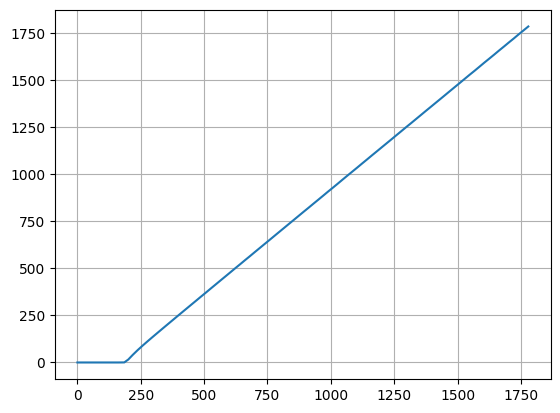

In [348]:
plot(mean(mean(np.asarray(E_net_record_EIIE/pamp),2),1),mean(np.asarray(rates_E_record_EIIE),2)[:,0])
grid()

In [ ]:
k_EI = []
k_IE = []
for i in range(90):
    k_EI.append(-(mean(np.asarray(rates_E_record_EIIE)[i,0,:])-(1.12*mean(mean(np.asarray(E_ext_record_EIIE/pamp),1),1)[i]-196))/mean(np.asarray(rates_I_record_EIIE)[i,0,:])/62.66)
    k_IE.append((mean(np.asarray(rates_I_record_EIIE)[i,0,:])-(1.12*mean(mean(np.asarray(I_ext_record_EIIE/pamp),1),1)[i]-196))/mean(np.asarray(rates_E_record_EIIE)[i,0,:])/62.66)
plot(mean(mean(np.asarray(I_net_record_EIIE/pamp),1),1),k_IE,label='I_net')
grid()
legend()
xlabel('current/mA')

# 与理论模型的比较

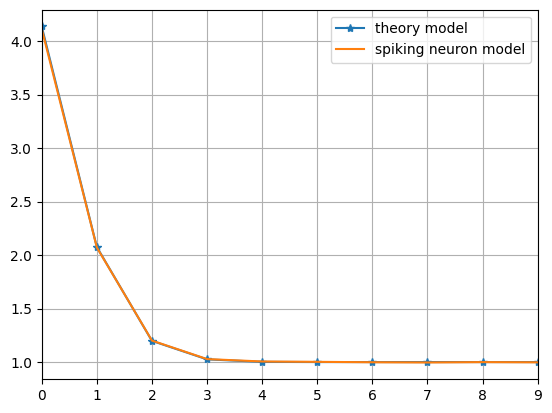

In [10]:
frequency = np.arange(0,180)
plot(frequency,theory_model(0.0121,0,0,25,frequency),'-*',label='theory model')
plot(np.asarray(delta_recordEE)/np.asarray(delta_record0),label='spiking neuron model')
xlim((0,9))
grid()
legend()

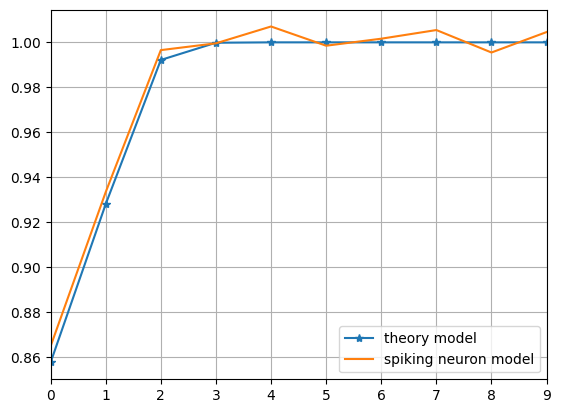

In [259]:
frequency = np.arange(0,180)
plot(frequency,theory_model(0,0.0047,0.009,25,frequency),'-*',label='theory model')
plot(np.asarray(delta_recordEIIE3)/np.asarray(delta_record0),label='spiking neuron model')
xlim((0,9))
grid()
legend()

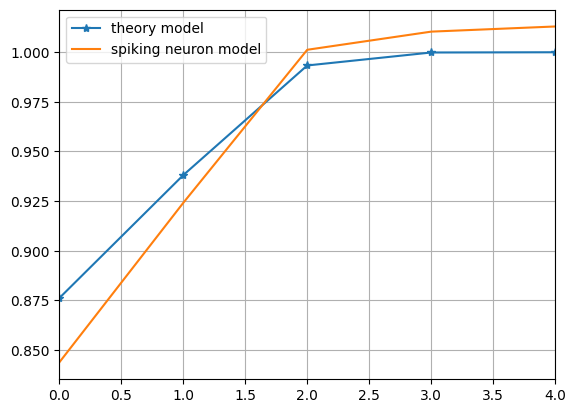

In [33]:
frequency = np.arange(0,180)
plot(frequency,theory_model(0,0.004,0.009,25,frequency),'-*',label='theory model')
plot(np.asarray(delta_recordEIIE1_append1)/np.asarray(delta_record0[:5]),label='spiking neuron model')
xlim((0,4))
grid()
legend()

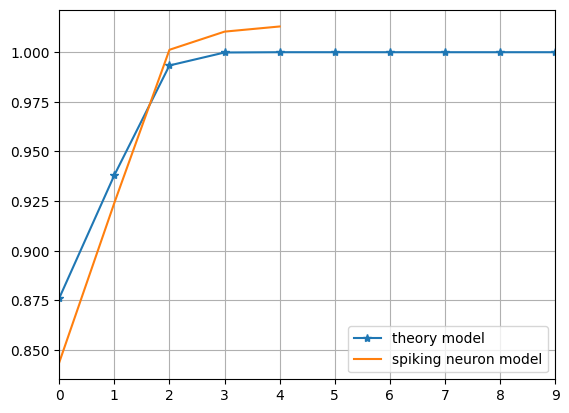

In [35]:
frequency = np.arange(0,180)
plot(frequency,theory_model(0,0.004,0.009,25,frequency),'-*',label='theory model')
plot(np.asarray(delta_recordEIIE1_append1)/np.asarray(delta_record0[:5]),label='spiking neuron model')
xlim((0,9))
grid()
legend()

Text(0.5, 0, 'fre')

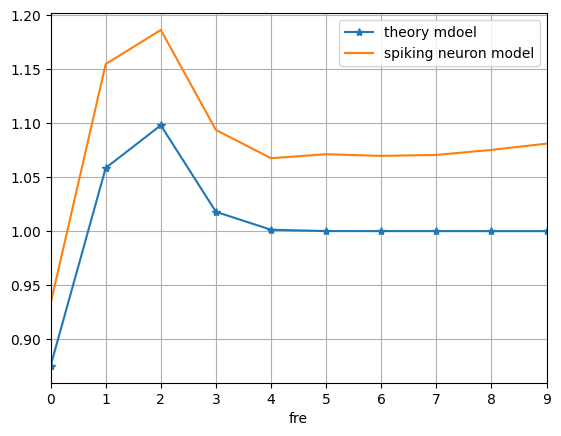

In [358]:
frequency = np.arange(0,180)
fig,axs = subplots(1,1)  
axs.plot(frequency,theory_model(0.009,0.01,0.018,25,frequency),'*-',label='theory mdoel')
axs.plot(np.asarray(delta_recordall2/(np.asarray(delta_record2)[:])),label='spiking neuron model')
axs.grid()
axs.legend()
axs.set_xlim((0,9))
axs.set_xlabel('fre')

# 相关实验结果的绘制

## sychonization test

In [24]:
E_spiket1_EIIE1[0],E_spikei1_EIIE1[0]

(array([2.569000e+00, 2.604000e+00, 2.613000e+00, ..., 9.999998e+03,
        9.999998e+03, 9.999998e+03]) * msecond,
 array([479, 256,   8, ..., 182, 276, 392], dtype=int32))

WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_18580/4202038523.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plot(E_spiket1_EIIE1[index][start_E:stop_E]/ms,theta[E_spikei1_EIIE1[index][start_E:stop_E]],'.k',color='r',label='E neuron')
 [py.warnings]
WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_18580/4202038523.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plot(I_spiket1_EIIE1[index][start_I:stop_I]/ms,180+theta[I_spikei1_EIIE1[index][start_I:stop_I]],'.k',color='g',label='I neuron')
 [py.warnings]


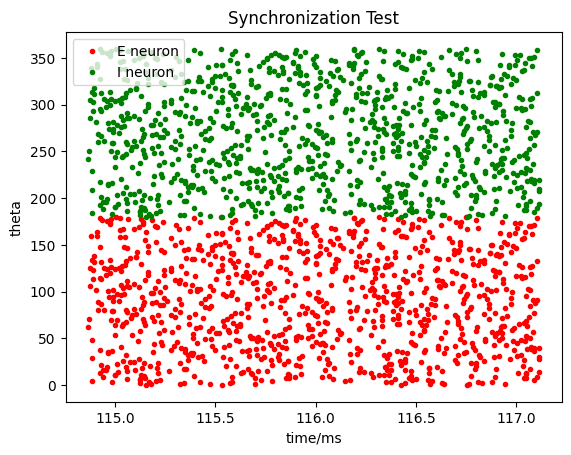

In [35]:
start_E=50000
start_I=50000
stop_E=start_E+1000
stop_I=start_I+1000
index = 4
theta = np.arange(0,600)/600*180

plot(E_spiket1_EIIE1[index][start_E:stop_E]/ms,theta[E_spikei1_EIIE1[index][start_E:stop_E]],'.k',color='r',label='E neuron')
plot(I_spiket1_EIIE1[index][start_I:stop_I]/ms,180+theta[I_spikei1_EIIE1[index][start_I:stop_I]],'.k',color='g',label='I neuron')
xlabel('time/ms')
ylabel('theta')
title('Synchronization Test')
legend()

## rates plot

In [ ]:
fig,axs = subplots(2,5,figsize = (40,10))
for i in range(2):
    for j in range(5):
        fft_y=np.fft.fft((np.asarray(r_EE11)-np.asarray(r_EE10))[2*i+j])
        fft_y0 = np.fft.fft((np.asarray(r11)-np.asarray(r10))[2*i+j])
        x = np.arange(600)           
        abs_y=np.abs(fft_y) 
        abs_y0=np.abs(fft_y0)      
        axs[i,j].plot(x,abs_y,label='EE')
        axs[i,j].plot(x,abs_y0,label='no connection')
        axs[i,j].set_xlim((0,20))
        axs[i,j].grid()
        axs[i,j].legend()
        axs[i,j].set_xlabel('fre')
        axs[i,j].set_title("input fre = "+str((5*i+j)))

## frequency plot

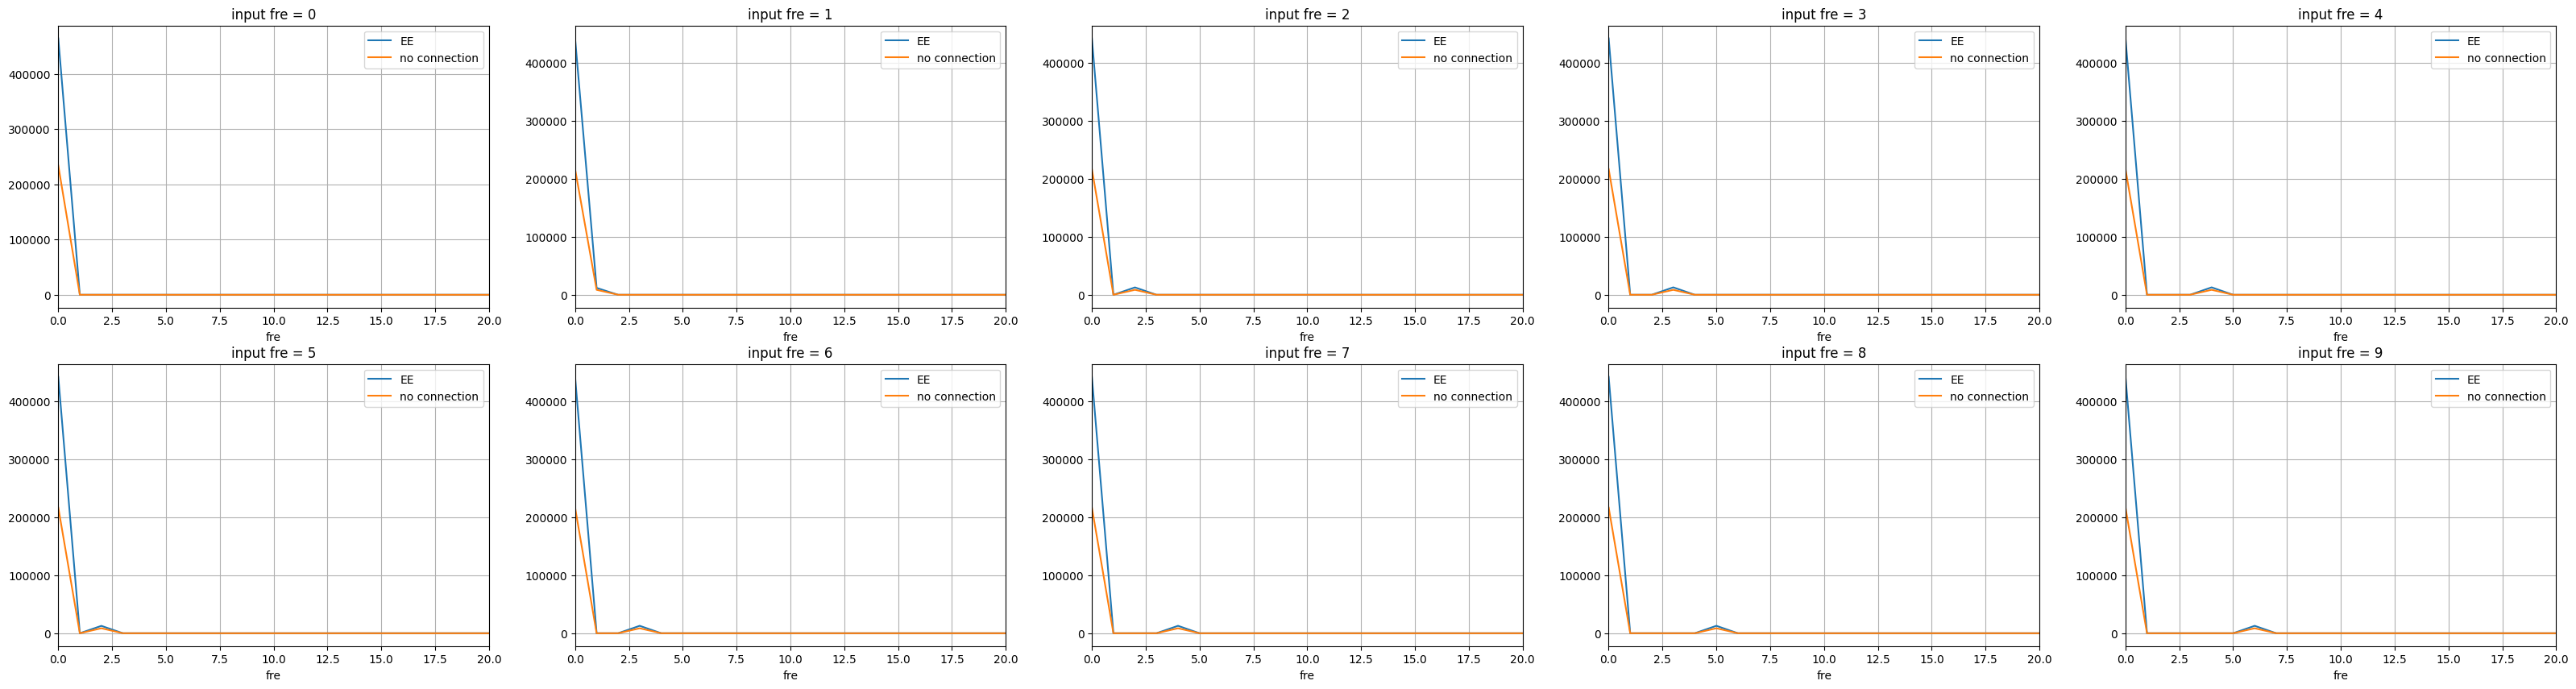

In [112]:
fig,axs = subplots(2,5,figsize = (40,10))
for i in range(2):
    for j in range(5):
        fft_y=np.fft.fft((np.asarray(r_EIIE11))[2*i+j])
        fft_y0 = np.fft.fft((np.asarray(r11))[2*i+j])
        x = np.arange(600)           
        abs_y=np.abs(fft_y) 
        abs_y0=np.abs(fft_y0)      
        axs[i,j].plot(x,abs_y,label='EE')
        axs[i,j].plot(x,abs_y0,label='no connection')
        axs[i,j].set_xlim((0,20))
        axs[i,j].grid()
        axs[i,j].legend()
        axs[i,j].set_xlabel('fre')
        axs[i,j].set_title("input fre = "+str((5*i+j)))